In [19]:
# import libraries
import numpy as np
import torch

# step 1: prep data set
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# step 2: build model
import torch.nn as nn
import torch.nn.functional as F

# step 3: train model
import torch.optim as optim

import os

In [2]:
# download, split, and preprocess the images

# formatting transformation to convert the images to tensors (easier for pytorch to handle and train on a GPU) and normalize the pixel values
transform = transforms.Compose(
    [s.ToTensor(),transform
     # normalize 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download the CIFAR10 dataset (only the training set) and apply the transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# create a dataloader to load the data in batches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=32)

# download the CIFAR10 dataset (only the test set) and apply the transformations
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# create a dataloader to load the data in batches 
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=32)

# define the classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 55.7MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


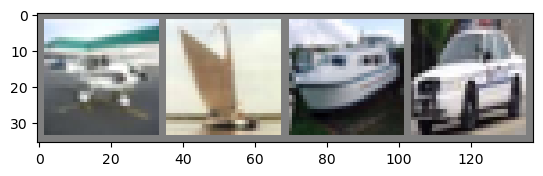

plane  ship  ship   car


In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.ion()
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# define network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  # Initialize the parent class (nn.Module)
        self.conv1 = nn.Conv2d(3, 6, 5) # First conv layer: 3 input channels/planes (RGB), 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with 2x2 window and stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)  # Second conv layer: 6 input channels (output of first conv layer), 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # First fully connected layer: 16*5*5 inputs, 120 outputs
        self.fc2 = nn.Linear(120, 84)  # Second fully connected layer: 120 inputs, 84 outputs
        self.fc3 = nn.Linear(84, 10)  # Output layer: 84 inputs, 10 outputs (CIFAR-10 classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU activation, and max pooling
        x = x.view(-1, 16 * 5 * 5)  # Flatten the feature maps (-1 for automatic batch size calculation)
        x = F.relu(self.fc1(x))  # Apply first fully connected layer with ReLU
        x = F.relu(self.fc2(x))  # Apply second fully connected layer with ReLU
        x = self.fc3(x)  # Apply output layer (logits)
        return x  # Return the output logits

net = Net()  # Instantiate the network

In [5]:
# define loss function and optimizer (cross-entropy loss and SGD with momentum)
criterion = nn.CrossEntropyLoss() # loss function -- generalizes for more than 2 classes (multi-class classification)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # optimizer -- stochastic gradient descent with momentum

# 0.9 momentum corresponds to recent 10 weight updates

# train the model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)  # Forward pass: compute model predictions (logits) for the current batch
        loss = criterion(outputs, labels)  # Calculate cross-entropy loss between predicted outputs and true labels
        loss.backward()  # Backpropagation: compute gradients of the loss w.r.t. all learnable parameters
        optimizer.step()  # Update all model parameters using the computed gradients and SGD with momentum

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.218
[1,  4000] loss: 1.866
[1,  6000] loss: 1.646
[1,  8000] loss: 1.552
[1, 10000] loss: 1.505
[1, 12000] loss: 1.461
[2,  2000] loss: 1.381
[2,  4000] loss: 1.376
[2,  6000] loss: 1.338
[2,  8000] loss: 1.332
[2, 10000] loss: 1.286
[2, 12000] loss: 1.269
Finished Training


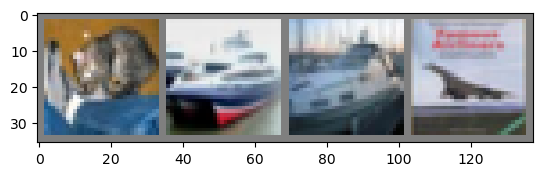

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car  ship


/tmp/ipykernel_486659/1230447647.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 54 %
Accuracy of plane : 57 %
Accuracy of   car : 83 %
Accuracy of  bird : 37 %
Accuracy of   cat : 36 %
Accuracy of  deer : 50 %
Accuracy of   dog : 43 %
Accuracy of  frog : 81 %
Accuracy of horse : 53 %
Accuracy of  ship : 56 %
Accuracy of truck : 40 %


In [6]:
# display images from test set
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# load trained network (only needed if you exited ipython after training)
net = Net()
net.load_state_dict(torch.load(PATH))

# object categories predicted by the network
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# accuracy on the full test data set (10,000 images)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# investigate performance per object categoryclass_correct = list(0. for i in range(10))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [7]:
transform = transforms.Compose([
    transforms.Resize((32,32)),               # downscale/crop to 32×32
    transforms.ToTensor(),                    # convert to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))     # same normalization as CIFAR-10
])

In [8]:
from PIL import Image

### Batch 1

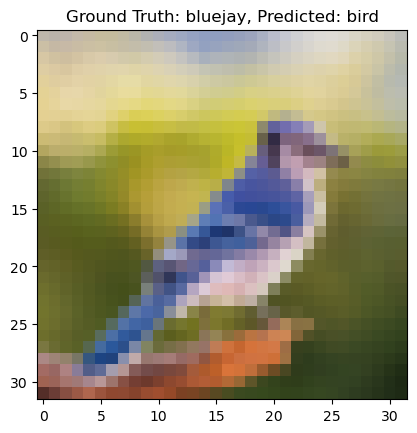

In [ ]:
img_path = "B1/bluejay.png"

img = Image.open(img_path)
img = transform(img).unsqueeze(0)

ground_truth = img_path.split("/")[-1].split(".")[0]

# feed to network and print prediction
output = net(img)
_, predicted = torch.max(output, 1)
predicted_class = classes[predicted]

# visualize image 
plt.figure()
plt.imshow(img.squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # denormalize
plt.title(f'Ground Truth: {ground_truth}, Predicted: {predicted_class}')
plt.savefig("results/{ground_truth}")

In [23]:
# Path to your folder with images
folder_path = "B1"
for folder_path in ["B1", "B2", "B3"]:
    # Loop over every file in the folder
    for filename in os.listdir(folder_path):
        # Check file extension
        # (you can add other valid extensions if needed)
        ext = os.path.splitext(filename)[1].lower()
        if ext not in {".png", ".jpg", ".jpeg"}:
            continue  # skip non-image files

        # Extract ground-truth name by removing extension
        ground_truth = os.path.splitext(filename)[0]

        # Build full path to the image
        img_path = os.path.join(folder_path, filename)

        # Load and transform the image
        img = Image.open(img_path)
        img_tensor = transform(img).unsqueeze(0)  # add batch dimension

        # Forward pass to get a prediction
        output = net(img_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = classes[predicted]

        # Visualize the image
        # Denormalize by undoing (img_tensor * 0.5 + 0.5)
        plt.figure(figsize=(5, 5), dpi=300)  # High DPI figure with square aspect ratio
        plt.imshow(img_tensor.squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f"Ground Truth: {ground_truth}, Predicted: {predicted_class}")
        plt.tight_layout()  # Trim excess white space
        plt.axis('tight')   # Further reduce margins around the image

        # Save the figure with a descriptive filename
        save_name = f"results/B1_{ground_truth}.png"
        plt.savefig(save_name)
        plt.close()

In [24]:
# get file names of the results folder and print each one 
for filename in os.listdir("results"):
    print(filename)

B1_cat_on_bed.png
B1_tractor.png
B1_kayak.png
B1_small_bird.png
B1_lion_cub.png
B1_street_with_cars.png
B1_bluejay.png
B1_butterfly.png
B1_dog.png
B1_car.png
B1_dog_in_park.png
B1_plane.png
